DAEN 690 - Capstone Project, Summer 2022
Team Launch Insight
Bray, Brensike, Rego, Williamson, Woods

In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
pd.options.display.max_colwidth = 100000

import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px

In [2]:
# Read pickle file with topics and augmented text
df_notam = pd.read_pickle("data/allData.pkl")

# Make MIN_ALT and MAX_ALT numeric
df_notam['MIN_ALT'] = df_notam['MIN_ALT'].replace('MSL', 0)
df_notam['MAX_ALT'] = df_notam['MAX_ALT'].replace('MSL', 0)
df_notam['MIN_ALT'] = pd.to_numeric(df_notam['MIN_ALT'], errors='coerce')
df_notam['MAX_ALT'] = pd.to_numeric(df_notam['MAX_ALT'], errors='coerce')

# Make POSSIBLE_START_DATE, POSSIBLE_END_DATE, ISSUE_DATE, and CANCELED_DATE datetime format
df_notam['POSSIBLE_START_DATE'] = pd.to_datetime(df_notam['POSSIBLE_START_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')
df_notam['POSSIBLE_END_DATE'] = pd.to_datetime(df_notam['POSSIBLE_END_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')
df_notam['ISSUE_DATE'] = pd.to_datetime(df_notam['ISSUE_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')
df_notam['CANCELED_DATE'] = pd.to_datetime(df_notam['CANCELED_DATE'], errors = 'coerce', format = '%Y/%m/%d %H:%M:%S')

# Replace missing POSSIBLE_START_DATE with CANCELED_DATE and vise versa
df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'CANCELED_DATE'] = df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'POSSIBLE_END_DATE']
df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'POSSIBLE_END_DATE'] = df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'CANCELED_DATE']

# Get mode of all NOTAM durations
est_days = (df_notam['POSSIBLE_END_DATE'] - df_notam['POSSIBLE_START_DATE']).mode()

# Fix remaining missing values of CANCELED_DATE and POSSIBLE_END_DATE by adding the mode to the POSSIBLE_START_DATE
df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'CANCELED_DATE'] = df_notam.loc[df_notam['CANCELED_DATE'].isna(), 'POSSIBLE_START_DATE'] + pd.to_timedelta(est_days.dt.days[0], unit='D')
df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'POSSIBLE_END_DATE'] = df_notam.loc[df_notam['POSSIBLE_END_DATE'].isna(), 'POSSIBLE_START_DATE'] + pd.to_timedelta(est_days.dt.days[0], unit='D')

# Drop NOTAMs without POSSIBLE_END_DATE and POSSIBLE_START_DATE
df_notam = df_notam.dropna( how='all', subset=['POSSIBLE_END_DATE', 'POSSIBLE_START_DATE'])

In [3]:
# Check missing values
df_notam.isna().sum()

NOTAM_REC_ID                    0
FNS_ID                          0
FILENAME                        0
NOTAM_ID                       26
NOTAM_TYPE                 221168
RELATED_NOTAM_ID          1281589
SIMPLE_TEXT                821736
LOC_ID_ACCOUNTABLE_ORG     864049
NOTAM_NUMBER               867227
RELATED_NOTAM_NUMBER      1524160
TEXT                            0
Q_CODE                     639786
Q_CODE_INTERPRETATION      909240
A_CODE                     508084
B_CODE                     666838
C_CODE                     820329
D_CODE                    1480096
E_CODE                        445
F_CODE                     629754
G_CODE                     629952
CLASSIFICATION                 31
POSSIBLE_NOTAM_ID              26
MIN_ALT                    461512
MAX_ALT                    514142
MIN_ALT_REF_TYPE           597577
MAX_ALT_REF_TYPE           665715
POSSIBLE_START_DATE             0
POSSIBLE_END_DATE               0
ISSUE_DATE                     26
CANCELED_DATE 

In [4]:
## Import Launch data
df_launch = pd.read_csv('data/launches_20201027.csv')

In [5]:
## Set of all launches
i_launch = (set(df_launch['LAUNCHES_REC_ID']))

In [6]:
## Pick launches to test by reducing the full set to the following...
# i_launch = [1,10,50,100,150,200,250,300,350,400,450,500]

In [7]:
## Focus on date/time columns only
dtg_notam = pd.DataFrame(df_notam, columns=['NOTAM_REC_ID','POSSIBLE_START_DATE','POSSIBLE_END_DATE'])
dtg_launch = pd.DataFrame(df_launch, columns=['LAUNCHES_REC_ID','LAUNCH_DATE'])

Compare the number of NOTAM active in our dataset at the time of each launch

In [8]:
for i in i_launch:
    j = i-1  ## index value is one less than i
    time = dtg_launch.at[j,'LAUNCH_DATE']

    # Date filter
    filter_dtg = dtg_notam[(dtg_notam['POSSIBLE_START_DATE'] <= time) & (dtg_notam['POSSIBLE_END_DATE'] >= time)]
    
    dtg_launch.at[j,'ORIG_NOTAM_COUNT'] = len(filter_dtg)

#     print(f'LAUNCH_REC_ID {i} had {len(filter_dtg)} active NOTAMs at launch time {time}')

In [9]:
print(dtg_launch)

     LAUNCHES_REC_ID          LAUNCH_DATE  ORIG_NOTAM_COUNT
0                  1  2013-01-05 00:00:00             134.0
1                  2  2013-01-26 22:00:00             139.0
2                  3  2013-01-26 22:50:00             139.0
3                  4  2013-01-31 01:48:00             142.0
4                  5  2013-02-01 06:56:00             142.0
..               ...                  ...               ...
513              514  2020-04-22 19:30:30            8601.0
514              515  2020-05-17 13:14:00            6503.0
515              516  2020-05-25 18:50:00            7362.0
516              517  2020-05-30 19:22:45            7742.0
517              518  2020-06-04 01:25:33            6406.0

[518 rows x 3 columns]


Reduce the dataset of notams, taking out notams active for more than 90 days

In [10]:
# Calculate the difference between start and end dates for notams
dtg_notam['diff_days'] = dtg_notam.POSSIBLE_END_DATE - dtg_notam.POSSIBLE_START_DATE
# Convert the difference to weeks
dtg_notam['diff_days'] = dtg_notam.diff_days / np.timedelta64(1, 'D')

dtg_notam

,NOTAM_REC_ID,POSSIBLE_START_DATE,POSSIBLE_END_DATE,diff_days
0,1,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
1,2,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
2,3,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
3,4,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
4,5,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
...,...,...,...,...
1649751,1650464,2020-06-01 11:00:00,2020-06-02 03:00:00,0.666667
1649752,1650465,2020-05-31 19:48:00,2020-06-03 19:48:00,3.000000
1649753,1650466,2020-06-01 15:00:00,2020-06-01 17:00:00,0.083333
1649754,1650467,2020-05-31 19:52:00,2020-06-01 01:00:00,0.213889


In [11]:
dtg_90days = dtg_notam[dtg_notam['diff_days'] <= 90]
dtg_90days

,NOTAM_REC_ID,POSSIBLE_START_DATE,POSSIBLE_END_DATE,diff_days
0,1,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
1,2,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
2,3,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
3,4,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
4,5,2016-05-24 17:30:00,2016-05-24 19:45:00,0.093750
...,...,...,...,...
1649751,1650464,2020-06-01 11:00:00,2020-06-02 03:00:00,0.666667
1649752,1650465,2020-05-31 19:48:00,2020-06-03 19:48:00,3.000000
1649753,1650466,2020-06-01 15:00:00,2020-06-01 17:00:00,0.083333
1649754,1650467,2020-05-31 19:52:00,2020-06-01 01:00:00,0.213889


In [12]:
for i in i_launch:
    j = i-1  ## index value is one less than i
    time = dtg_launch.at[j,'LAUNCH_DATE']

    # Date filter
    filter_dtg = dtg_90days[(dtg_90days['POSSIBLE_START_DATE'] <= time) & (dtg_90days['POSSIBLE_END_DATE'] >= time)]

    dtg_launch.at[j,'NOTAM_COUNT'] = len(filter_dtg)

    print(f'LAUNCH_REC_ID {i} had {len(filter_dtg)} active NOTAMs at launch time {time}')

LAUNCH_REC_ID 1 had 0 active NOTAMs at launch time 2013-01-05 00:00:00
LAUNCH_REC_ID 2 had 0 active NOTAMs at launch time 2013-01-26 22:00:00
LAUNCH_REC_ID 3 had 0 active NOTAMs at launch time 2013-01-26 22:50:00
LAUNCH_REC_ID 4 had 0 active NOTAMs at launch time 2013-01-31 01:48:00
LAUNCH_REC_ID 5 had 0 active NOTAMs at launch time 2013-02-01 06:56:00
LAUNCH_REC_ID 6 had 0 active NOTAMs at launch time 2013-02-07 08:21:00
LAUNCH_REC_ID 7 had 0 active NOTAMs at launch time 2013-02-11 18:02:00
LAUNCH_REC_ID 8 had 0 active NOTAMs at launch time 2013-02-13 09:10:00
LAUNCH_REC_ID 9 had 0 active NOTAMs at launch time 2013-02-13 09:15:00
LAUNCH_REC_ID 10 had 0 active NOTAMs at launch time 2013-02-15 16:34:00
LAUNCH_REC_ID 11 had 0 active NOTAMs at launch time 2013-03-01 15:10:00
LAUNCH_REC_ID 12 had 0 active NOTAMs at launch time 2013-03-06 12:00:00
LAUNCH_REC_ID 13 had 0 active NOTAMs at launch time 2013-03-11 06:10:00
LAUNCH_REC_ID 14 had 0 active NOTAMs at launch time 2013-03-19 21:21:00
L

LAUNCH_REC_ID 125 had 1 active NOTAMs at launch time 2014-08-23 01:12:00
LAUNCH_REC_ID 126 had 1 active NOTAMs at launch time 2014-08-24 20:24:00
LAUNCH_REC_ID 127 had 1 active NOTAMs at launch time 2014-08-27 21:07:00
LAUNCH_REC_ID 128 had 1 active NOTAMs at launch time 2014-08-28 02:52:00
LAUNCH_REC_ID 129 had 0 active NOTAMs at launch time 2014-09-07 05:00:00
LAUNCH_REC_ID 130 had 0 active NOTAMs at launch time 2014-09-17 00:10:00
LAUNCH_REC_ID 131 had 0 active NOTAMs at launch time 2014-09-21 05:52:03
LAUNCH_REC_ID 132 had 0 active NOTAMs at launch time 2014-09-23 02:38:00
LAUNCH_REC_ID 133 had 0 active NOTAMs at launch time 2014-09-30 06:00:00
LAUNCH_REC_ID 134 had 0 active NOTAMs at launch time 2014-10-07 04:04:00
LAUNCH_REC_ID 135 had 0 active NOTAMs at launch time 2014-10-11 16:33:00
LAUNCH_REC_ID 136 had 1 active NOTAMs at launch time 2014-10-16 19:12:00
LAUNCH_REC_ID 137 had 2 active NOTAMs at launch time 2014-10-23 01:26:00
LAUNCH_REC_ID 138 had 0 active NOTAMs at launch tim

LAUNCH_REC_ID 242 had 412 active NOTAMs at launch time 2016-04-08 20:43:31
LAUNCH_REC_ID 243 had 1369 active NOTAMs at launch time 2016-05-06 05:21:00
LAUNCH_REC_ID 244 had 1577 active NOTAMs at launch time 2016-05-11 18:30:00
LAUNCH_REC_ID 245 had 1838 active NOTAMs at launch time 2016-05-17 18:57:00
LAUNCH_REC_ID 246 had 2624 active NOTAMs at launch time 2016-05-24 12:00:00
LAUNCH_REC_ID 247 had 3920 active NOTAMs at launch time 2016-05-25 12:00:00
LAUNCH_REC_ID 248 had 7072 active NOTAMs at launch time 2016-05-26 21:40:00
LAUNCH_REC_ID 249 had 6570 active NOTAMs at launch time 2016-05-27 21:39:00
LAUNCH_REC_ID 250 had 4382 active NOTAMs at launch time 2016-05-30 12:00:00
LAUNCH_REC_ID 251 had 4326 active NOTAMs at launch time 2016-06-01 06:57:00
LAUNCH_REC_ID 252 had 4038 active NOTAMs at launch time 2016-06-09 17:59:00
LAUNCH_REC_ID 253 had 3939 active NOTAMs at launch time 2016-06-11 17:51:00
LAUNCH_REC_ID 254 had 6103 active NOTAMs at launch time 2016-06-15 14:29:00
LAUNCH_REC_ID

LAUNCH_REC_ID 350 had 13557 active NOTAMs at launch time 2017-10-06 08:00:00
LAUNCH_REC_ID 351 had 13521 active NOTAMs at launch time 2017-10-07 07:59:00
LAUNCH_REC_ID 352 had 13048 active NOTAMs at launch time 2017-10-09 12:37:01
LAUNCH_REC_ID 353 had 14403 active NOTAMs at launch time 2017-10-11 22:53:00
LAUNCH_REC_ID 354 had 16122 active NOTAMs at launch time 2017-10-14 07:31:00
LAUNCH_REC_ID 355 had 15416 active NOTAMs at launch time 2017-10-15 07:28:00
LAUNCH_REC_ID 356 had 10573 active NOTAMs at launch time 2017-10-29 22:04:00
LAUNCH_REC_ID 357 had 10586 active NOTAMs at launch time 2017-10-30 00:57:00
LAUNCH_REC_ID 358 had 12310 active NOTAMs at launch time 2017-10-30 19:34:00
LAUNCH_REC_ID 359 had 13130 active NOTAMs at launch time 2017-10-31 21:37:00
LAUNCH_REC_ID 360 had 9525 active NOTAMs at launch time 2017-11-11 12:30:00
LAUNCH_REC_ID 361 had 9662 active NOTAMs at launch time 2017-11-12 12:19:51
LAUNCH_REC_ID 362 had 11526 active NOTAMs at launch time 2017-11-14 09:47:00
L

LAUNCH_REC_ID 468 had 7509 active NOTAMs at launch time 2019-06-12 14:17:10
LAUNCH_REC_ID 469 had 8249 active NOTAMs at launch time 2019-06-19 21:36:00
LAUNCH_REC_ID 470 had 8673 active NOTAMs at launch time 2019-06-25 06:30:00
LAUNCH_REC_ID 471 had 6050 active NOTAMs at launch time 2019-07-01 00:00:00
LAUNCH_REC_ID 472 had 7776 active NOTAMs at launch time 2019-07-01 23:02:00
LAUNCH_REC_ID 473 had 7783 active NOTAMs at launch time 2019-07-25 00:00:00
LAUNCH_REC_ID 474 had 7993 active NOTAMs at launch time 2019-07-25 22:01:56
LAUNCH_REC_ID 475 had 7136 active NOTAMs at launch time 2019-08-06 23:23:00
LAUNCH_REC_ID 476 had 9545 active NOTAMs at launch time 2019-08-08 10:13:00
LAUNCH_REC_ID 477 had 9926 active NOTAMs at launch time 2019-08-10 18:00:00
LAUNCH_REC_ID 478 had 9097 active NOTAMs at launch time 2019-08-11 21:50:00
LAUNCH_REC_ID 479 had 9750 active NOTAMs at launch time 2019-08-22 13:06:00
LAUNCH_REC_ID 480 had 9173 active NOTAMs at launch time 2019-08-27 00:00:00
LAUNCH_REC_I

In [13]:
print(dtg_launch)

     LAUNCHES_REC_ID          LAUNCH_DATE  ORIG_NOTAM_COUNT  NOTAM_COUNT
0                  1  2013-01-05 00:00:00             134.0          0.0
1                  2  2013-01-26 22:00:00             139.0          0.0
2                  3  2013-01-26 22:50:00             139.0          0.0
3                  4  2013-01-31 01:48:00             142.0          0.0
4                  5  2013-02-01 06:56:00             142.0          0.0
..               ...                  ...               ...          ...
513              514  2020-04-22 19:30:30            8601.0       5742.0
514              515  2020-05-17 13:14:00            6503.0       3841.0
515              516  2020-05-25 18:50:00            7362.0       4703.0
516              517  2020-05-30 19:22:45            7742.0       5075.0
517              518  2020-06-04 01:25:33            6406.0       3742.0

[518 rows x 4 columns]


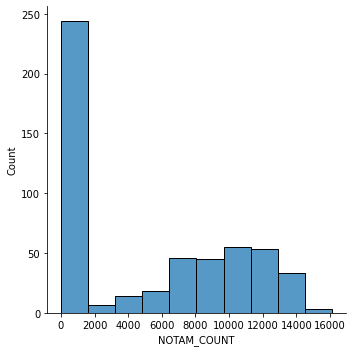

In [14]:
# sns.boxplot(x=dtg_launch['LAUNCH_DATE'], y=dtg_launch['NOTAM_COUNT'])

sns.displot(dtg_launch['NOTAM_COUNT'], bins=10)

<AxesSubplot:xlabel='NOTAM_COUNT', ylabel='Count'>

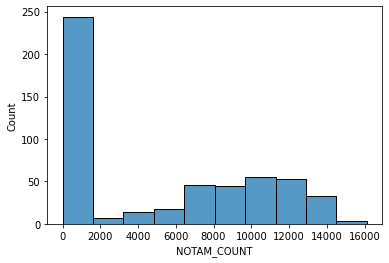

In [15]:
sns.histplot(dtg_launch['NOTAM_COUNT'], bins=10)

<AxesSubplot:xlabel='ORIG_NOTAM_COUNT', ylabel='Count'>

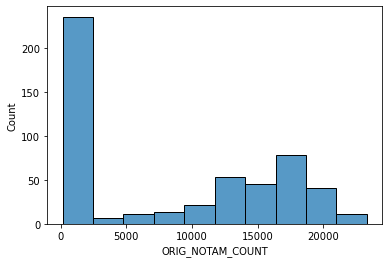

In [16]:
sns.histplot(dtg_launch['ORIG_NOTAM_COUNT'], bins=10)

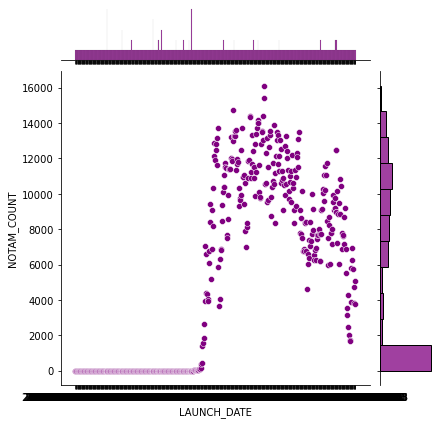

In [17]:
sns.jointplot(x = "LAUNCH_DATE", y = "NOTAM_COUNT", data = dtg_launch, color="purple")

In [18]:
## Extract date and year to get better graphs

dtg_launch['year'] = pd.DatetimeIndex(dtg_launch['LAUNCH_DATE']).year
dtg_launch['month'] = pd.DatetimeIndex(dtg_launch['LAUNCH_DATE']).month
print(dtg_launch)

     LAUNCHES_REC_ID          LAUNCH_DATE  ORIG_NOTAM_COUNT  NOTAM_COUNT  \
0                  1  2013-01-05 00:00:00             134.0          0.0   
1                  2  2013-01-26 22:00:00             139.0          0.0   
2                  3  2013-01-26 22:50:00             139.0          0.0   
3                  4  2013-01-31 01:48:00             142.0          0.0   
4                  5  2013-02-01 06:56:00             142.0          0.0   
..               ...                  ...               ...          ...   
513              514  2020-04-22 19:30:30            8601.0       5742.0   
514              515  2020-05-17 13:14:00            6503.0       3841.0   
515              516  2020-05-25 18:50:00            7362.0       4703.0   
516              517  2020-05-30 19:22:45            7742.0       5075.0   
517              518  2020-06-04 01:25:33            6406.0       3742.0   

     year  month  
0    2013      1  
1    2013      1  
2    2013      1  
3    2013  

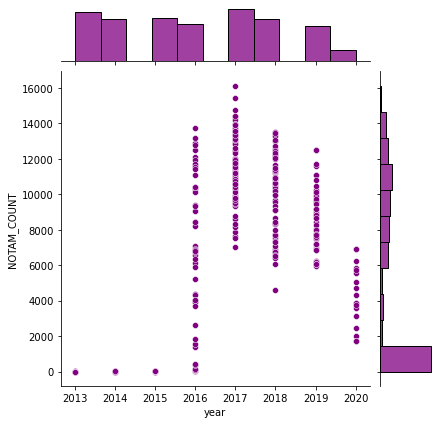

In [19]:
sns.jointplot(x = "year", y = "NOTAM_COUNT", data = dtg_launch, color="purple")

<AxesSubplot:xlabel='year', ylabel='Count'>

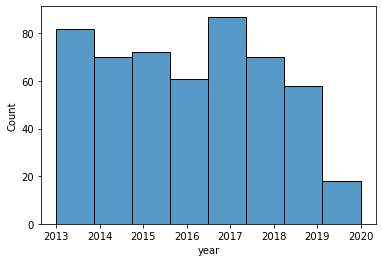

In [20]:
## Launches by year
sns.histplot(dtg_launch['year'], bins=8)

<AxesSubplot:xlabel='month', ylabel='Count'>

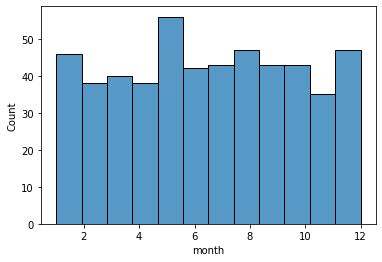

In [21]:
## Launches by month, regardless of year
sns.histplot(dtg_launch['month'], bins=12)

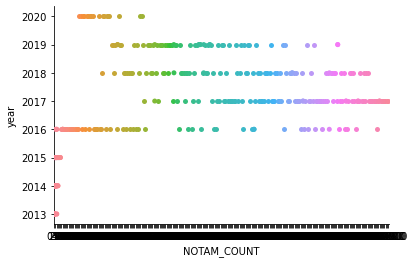

In [22]:
p = sns.stripplot(x = 'NOTAM_COUNT', y = "year", data = dtg_launch, size = 5)

# remove the top and right line in graph
sns.despine()
# p.figure.set_size_inches(12,16)
plt.show()

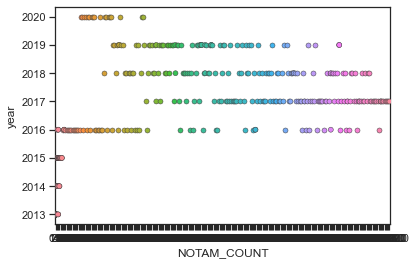

In [23]:
# sns.set_theme(style="whitegrid")
sns.set_theme(style="ticks")

ax = sns.stripplot(x="NOTAM_COUNT", y="year", data=dtg_launch, linewidth=0.5)

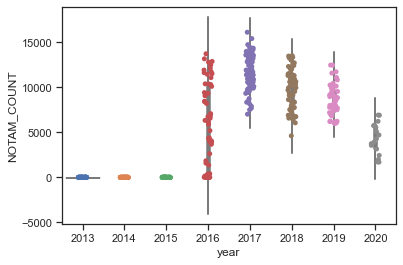

In [24]:
## Show notam counts for launches by year
ax = sns.violinplot(x="year", y="NOTAM_COUNT", data=dtg_launch, color="0.8")
ax = sns.stripplot(x="year", y="NOTAM_COUNT", data=dtg_launch)